Running simulation with history tracking...

Transmission Count by Category:
Category A: 5126 times
Category B: 5334 times
Category C: 4471 times

Selecting nodes for spline reconstruction...
Selected nodes: {'Category A': 'mote1', 'Category B': 'mote18', 'Category C': 'mote36'}
Generating spline reconstruction for mote1 (Category A)...
Generating spline reconstruction for mote18 (Category B)...
Generating spline reconstruction for mote36 (Category C)...

Full view spline reconstruction saved to 'spline_reconstruction_full_view.png'
Zoomed spline reconstruction saved to 'spline_reconstruction_zoomed_view.png'


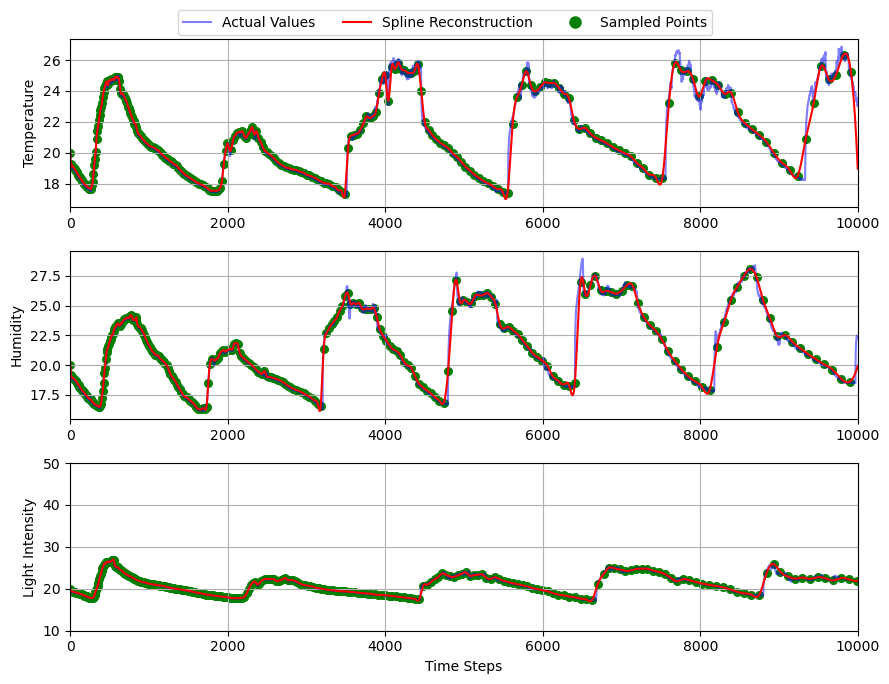

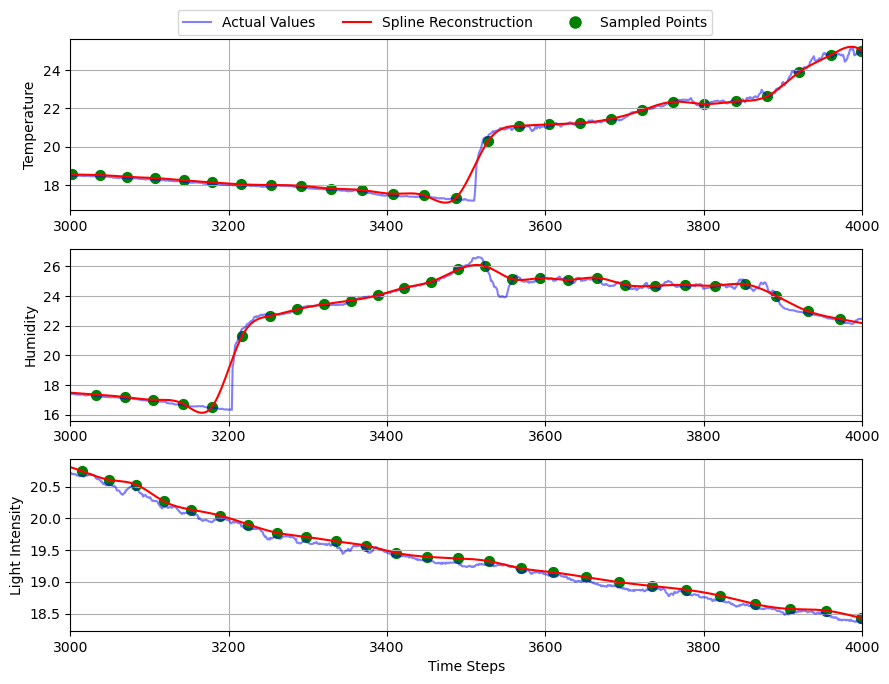

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("top_fifty_motes_temperatures.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("simulated_environment_data.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.3
M = 5 # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9 # dEWMA parameter for state value
beta_2 = 0.01 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to categorize node based on ID
def categorize_node(node_id):
    if 1 <= node_id <= 17:
        return 'Category A'
    elif 18 <= node_id <= 35:
        return 'Category B'
    elif 36 <= node_id <= 50:
        return 'Category C'
    return None

# Main function to simulate Whittle AoII with history tracking for spline reconstruction
def run_simulation_whittle_aoii_with_history(pivot_df, columns, M, theta, penalty, aoii_penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # New: Store history of all updates for spline reconstruction
    update_history = {col: {'times': [0], 'values': [20.0], 'rates': [0.1]} for col in columns}
    
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = t - last_update_times[col]  # Time since last update

            # Update node state and last update time
            new_state_value, new_rate_of_change = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            state_node[col] = np.array([new_state_value, new_rate_of_change])
            last_update_times[col] = t
            
            # New: Store update in history for spline reconstruction
            update_history[col]['times'].append(t)
            update_history[col]['values'].append(new_state_value)
            #update_history[col]['values'].append(measured_value)
            update_history[col]['rates'].append(new_rate_of_change)

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                category = categorize_node(node_id)
                if category:
                    category_counts[category] += 1

        # Step 4: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts, update_history

# Function to generate spline reconstruction for a node
def generate_spline_reconstruction(pivot_df, node, update_history):
    """
    Generate spline reconstruction for a node using its update history.
    
    Args:
        pivot_df: Original data DataFrame
        node: Column name of the node to reconstruct
        update_history: Dictionary containing update history for all nodes
        
    Returns:
        Tuple of arrays for (time_points, actual_values, reconstructed_values, update_times, update_values)
    """
    # Get update history for this node
    times = np.array(update_history[node]['times'])
    values = np.array(update_history[node]['values'])
    rates = np.array(update_history[node]['rates'])
    
    # Skip if we don't have enough points for spline
    if len(times) < 4:
        print(f"Not enough update points for {node} to generate spline")
        return None, None, None, None, None
    
    # Get actual values from dataset for comparison
    all_time_points = np.arange(len(pivot_df))
    actual_values = pivot_df[node].values
    
    # Create cubic spline using the values
    cs = CubicSpline(times, values)
    reconstructed_values = cs(all_time_points)
    
    # Create a better spline using both values and rates of change (hermite cubic spline)
    # This is more complex but would give better reconstruction using both x1 and x2
    # For simplicity, we'll use the basic cubic spline for now
    
    return all_time_points, actual_values, reconstructed_values, times, values

# Run the simulation with history tracking
print("Running simulation with history tracking...")
cumulative_rewards, category_counts, update_history = run_simulation_whittle_aoii_with_history(
    pivot_df, columns, M, theta, penalty, aoii_penalty
)

# Print the number of times each category was pulled
print("\nTransmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Select one node from each category for spline reconstruction
# We'll select the first node in each category that has enough update points
print("\nSelecting nodes for spline reconstruction...")

selected_nodes = {}
for col in columns:
    node_id = extract_node_id(col)
    if node_id is None:
        continue
    
    category = categorize_node(node_id)
    if category and category not in selected_nodes and len(update_history[col]['times']) >= 4:
        selected_nodes[category] = col

print(f"Selected nodes: {selected_nodes}")

# First figure: Full view
fig1, axes1 = plt.subplots(3, 1, figsize=(9, 7))

# Create a common legend for full view plots
legend_elements = [
    plt.Line2D([0], [0], color='b', alpha=0.5, label='Actual Values'),
    plt.Line2D([0], [0], color='r', label='Spline Reconstruction'),
    plt.Line2D([0], [0], marker='o', color='g', linestyle='None', markersize=8, label='Sampled Points')
]

# Add a single legend to the top of the first figure
fig1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=3, fancybox=True)

# Define simple labels for y-axis
y_labels = ['Temperature', 'Humidity', 'Light Intensity']

# Loop through categories and generate full view plots
for i, (category, node) in enumerate(selected_nodes.items()):
    print(f"Generating spline reconstruction for {node} ({category})...")
    
    time_points, actual, reconstructed, update_times, update_values = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Full view plots
    ax = axes1[i]
    ax.plot(time_points, actual, 'b-', alpha=0.5)
    ax.plot(time_points, reconstructed, 'r-')
    ax.scatter(update_times, update_values, c='g', marker='o', s=30)
    ax.set_ylabel(y_labels[i])
    ax.set_xlim(0, 10000)  # Set x-axis limit for full view
    
    # Set specific y-limit for Light Intensity plot (top subplot)
    if i == 2:  # First subplot (top)
       
         ax.set_ylim(10, 50)
    ax.grid(True)
    
    # Only add x-axis label to the bottom subplot
    if i == 2:
        ax.set_xlabel('Time Steps')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig("spline_reconstruction_full_view.png", dpi=300)
print("\nFull view spline reconstruction saved to 'spline_reconstruction_full_view.png'")

# Second figure: Zoomed view
fig2, axes2 = plt.subplots(3, 1, figsize=(9, 7))

# Add a single legend to the top of the second figure
fig2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=3, fancybox=True)

# Choose a window size for zoomed view
window_size = 1000
start_time = 3000  # Example starting point

# Loop through categories and generate zoomed view plots
for i, (category, node) in enumerate(selected_nodes.items()):
    time_points, actual, reconstructed, update_times, update_values = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Filter data for zoom window
    mask = (time_points >= start_time) & (time_points < start_time + window_size)
    update_mask = (update_times >= start_time) & (update_times < start_time + window_size)
    
    # Zoomed view plots
    ax = axes2[i]
    ax.plot(time_points[mask], actual[mask], 'b-', alpha=0.5)
    ax.plot(time_points[mask], reconstructed[mask], 'r-')
    ax.scatter(update_times[update_mask], update_values[update_mask], c='g', marker='o', s=50)
    ax.set_ylabel(y_labels[i])
    ax.set_xlim(3000, 4000)  # Set x-axis limit for zoomed view
    
    # Set specific y-limit for Light Intensity plot (top subplot)
  
        
    ax.grid(True)
    
    # Only add x-axis label to the bottom subplot
    if i == 2:
        ax.set_xlabel('Time Steps')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig("spline_reconstruction_zoomed_view.png", dpi=300)
print("Zoomed spline reconstruction saved to 'spline_reconstruction_zoomed_view.png'")

plt.show()

Running simulation with history tracking...

Transmission Count by Category:
Category A: 5126 times
Category B: 5334 times
Category C: 4471 times

Total sampled data points: 14931 out of 50000 possible points
Sampling rate: 29.86%

Selecting nodes for spline reconstruction...
Selected nodes: {'Category A': 'mote1', 'Category B': 'mote18', 'Category C': 'mote36'}
Generating spline reconstruction for mote1 (Category A)...
Generating spline reconstruction for mote18 (Category B)...
Generating spline reconstruction for mote36 (Category C)...

Full view spline reconstruction saved to 'spline_reconstruction_full_view.png'
Zoomed spline reconstruction saved to 'spline_reconstruction_zoomed_view.png'

RMSE Summary:
Category A (mote1): RMSE = 0.3816, Samples = 302 (3.02%)
Category B (mote18): RMSE = 0.4055, Samples = 304 (3.04%)
Category C (mote36): RMSE = 0.2580, Samples = 303 (3.03%)

Overall RMSE across all selected nodes: 0.3543


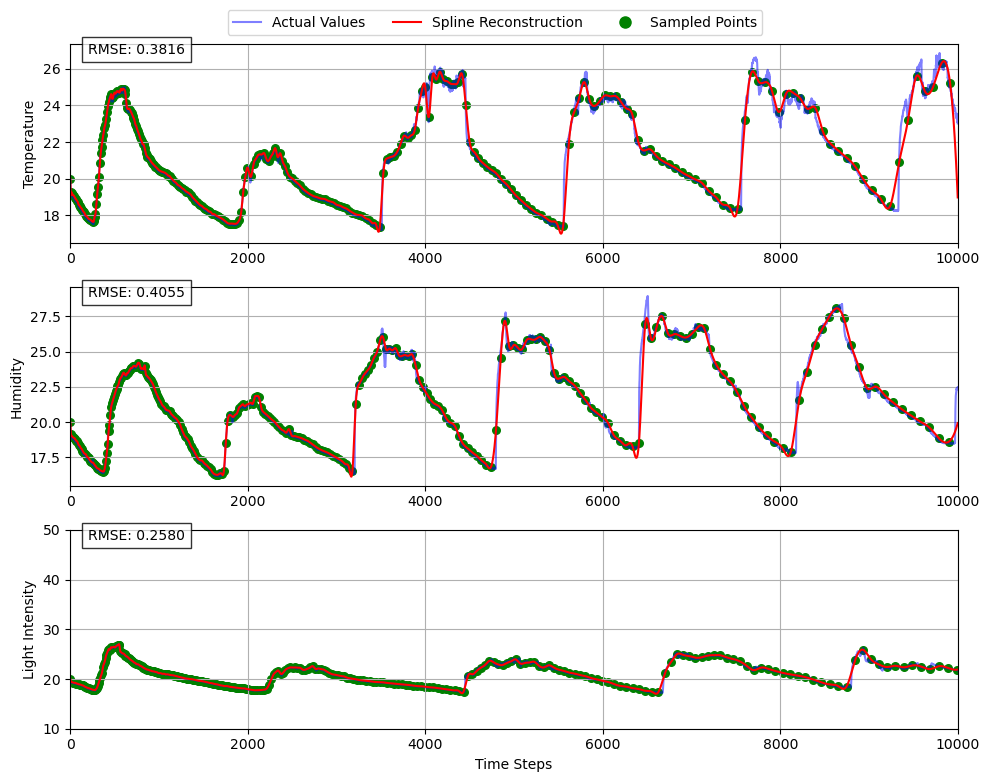

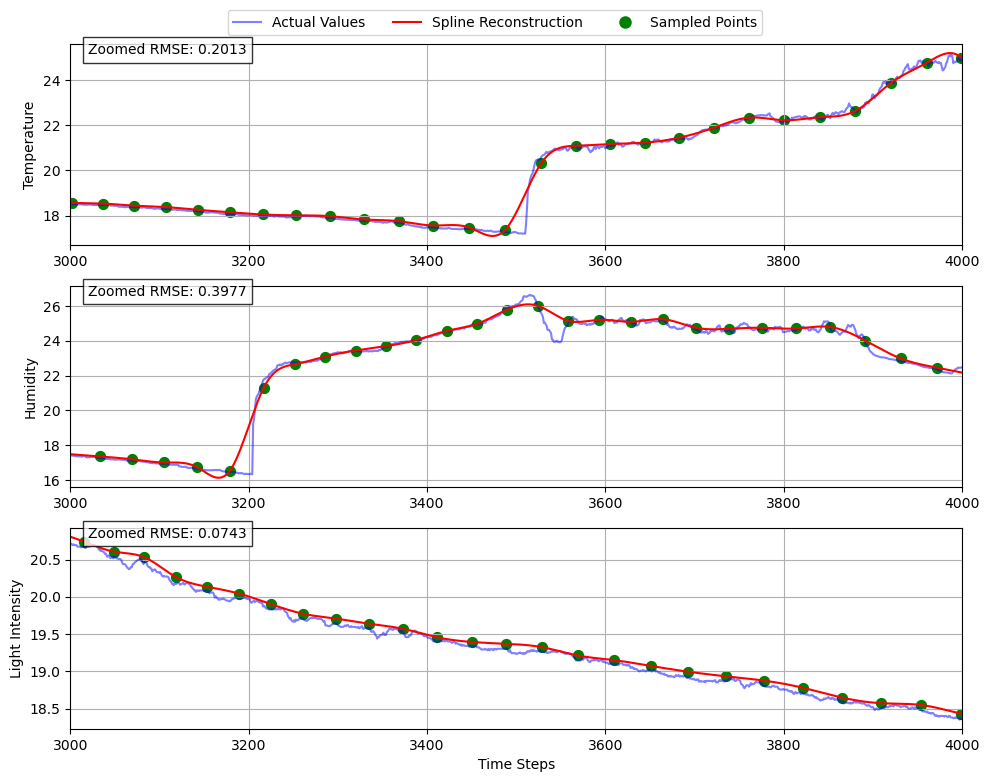

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("top_fifty_motes_temperatures.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("simulated_environment_data.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.3
M = 5 # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9 # dEWMA parameter for state value
beta_2 = 0.01 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to categorize node based on ID
def categorize_node(node_id):
    if 1 <= node_id <= 17:
        return 'Category A'
    elif 18 <= node_id <= 35:
        return 'Category B'
    elif 36 <= node_id <= 50:
        return 'Category C'
    return None

# Main function to simulate Whittle AoII with history tracking for spline reconstruction
def run_simulation_whittle_aoii_with_history(pivot_df, columns, M, theta, penalty, aoii_penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # New: Store history of all updates for spline reconstruction
    update_history = {col: {'times': [0], 'values': [20.0], 'rates': [0.1]} for col in columns}
    
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = t - last_update_times[col]  # Time since last update

            # Update node state and last update time
            new_state_value, new_rate_of_change = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            state_node[col] = np.array([new_state_value, new_rate_of_change])
            last_update_times[col] = t
            
            # New: Store update in history for spline reconstruction
            update_history[col]['times'].append(t)
            update_history[col]['values'].append(new_state_value)
            #update_history[col]['values'].append(measured_value)
            update_history[col]['rates'].append(new_rate_of_change)

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                category = categorize_node(node_id)
                if category:
                    category_counts[category] += 1

        # Step 4: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts, update_history

# Function to generate spline reconstruction for a node and calculate RMSE
def generate_spline_reconstruction(pivot_df, node, update_history):
    """
    Generate spline reconstruction for a node using its update history.
    
    Args:
        pivot_df: Original data DataFrame
        node: Column name of the node to reconstruct
        update_history: Dictionary containing update history for all nodes
        
    Returns:
        Tuple of arrays for (time_points, actual_values, reconstructed_values, update_times, update_values, rmse)
    """
    # Get update history for this node
    times = np.array(update_history[node]['times'])
    values = np.array(update_history[node]['values'])
    rates = np.array(update_history[node]['rates'])
    
    # Skip if we don't have enough points for spline
    if len(times) < 4:
        print(f"Not enough update points for {node} to generate spline")
        return None, None, None, None, None, None
    
    # Get actual values from dataset for comparison
    all_time_points = np.arange(len(pivot_df))
    actual_values = pivot_df[node].values
    
    # Create cubic spline using the values
    cs = CubicSpline(times, values)
    reconstructed_values = cs(all_time_points)
    
    # Calculate RMSE between actual and reconstructed values
    rmse = np.sqrt(mean_squared_error(actual_values, reconstructed_values))
    
    return all_time_points, actual_values, reconstructed_values, times, values, rmse

# Run the simulation with history tracking
print("Running simulation with history tracking...")
cumulative_rewards, category_counts, update_history = run_simulation_whittle_aoii_with_history(
    pivot_df, columns, M, theta, penalty, aoii_penalty
)

# Print the number of times each category was pulled
print("\nTransmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Calculate total sampled data points
total_sampled = sum(category_counts.values())
total_possible = len(pivot_df) * M
sampling_rate = (total_sampled / total_possible) * 100
print(f"\nTotal sampled data points: {total_sampled} out of {total_possible} possible points")
print(f"Sampling rate: {sampling_rate:.2f}%")

# Select one node from each category for spline reconstruction
# We'll select the first node in each category that has enough update points
print("\nSelecting nodes for spline reconstruction...")

selected_nodes = {}
for col in columns:
    node_id = extract_node_id(col)
    if node_id is None:
        continue
    
    category = categorize_node(node_id)
    if category and category not in selected_nodes and len(update_history[col]['times']) >= 4:
        selected_nodes[category] = col

print(f"Selected nodes: {selected_nodes}")

# Store RMSE values for each category
rmse_values = {}

# First figure: Full view with RMSE values
fig1, axes1 = plt.subplots(3, 1, figsize=(10, 8))

# Create a common legend for full view plots
legend_elements = [
    plt.Line2D([0], [0], color='b', alpha=0.5, label='Actual Values'),
    plt.Line2D([0], [0], color='r', label='Spline Reconstruction'),
    plt.Line2D([0], [0], marker='o', color='g', linestyle='None', markersize=8, label='Sampled Points')
]

# Add a single legend to the top of the first figure
fig1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=3, fancybox=True)

# Define simple labels for y-axis
y_labels = ['Temperature', 'Humidity', 'Light Intensity']

# Loop through categories and generate full view plots
for i, (category, node) in enumerate(selected_nodes.items()):
    print(f"Generating spline reconstruction for {node} ({category})...")
    
    time_points, actual, reconstructed, update_times, update_values, rmse = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Store RMSE for this category
    rmse_values[category] = rmse
    
    # Full view plots
    ax = axes1[i]
    ax.plot(time_points, actual, 'b-', alpha=0.5)
    ax.plot(time_points, reconstructed, 'r-')
    ax.scatter(update_times, update_values, c='g', marker='o', s=30)
    
    # Add RMSE to the plot
    ax.text(0.02, 0.95, f'RMSE: {rmse:.4f}', transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_ylabel(y_labels[i])
    ax.set_xlim(0, 10000)  # Set x-axis limit for full view
    
    # Set specific y-limit for Light Intensity plot (top subplot)
    if i == 2:  # First subplot (top)
        ax.set_ylim(10, 50)
    ax.grid(True)
    
    # Only add x-axis label to the bottom subplot
    if i == 2:
        ax.set_xlabel('Time Steps')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig("spline_reconstruction_full_view.png", dpi=300)
print("\nFull view spline reconstruction saved to 'spline_reconstruction_full_view.png'")

# Second figure: Zoomed view with RMSE
fig2, axes2 = plt.subplots(3, 1, figsize=(10, 8))

# Add a single legend to the top of the second figure
fig2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=3, fancybox=True)

# Choose a window size for zoomed view
window_size = 1000
start_time = 3000  # Example starting point

# Loop through categories and generate zoomed view plots with RMSE
for i, (category, node) in enumerate(selected_nodes.items()):
    time_points, actual, reconstructed, update_times, update_values, rmse = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Filter data for zoom window
    mask = (time_points >= start_time) & (time_points < start_time + window_size)
    update_mask = (update_times >= start_time) & (update_times < start_time + window_size)
    
    # Calculate RMSE for the zoomed section
    zoom_rmse = np.sqrt(mean_squared_error(actual[mask], reconstructed[mask]))
    
    # Zoomed view plots
    ax = axes2[i]
    ax.plot(time_points[mask], actual[mask], 'b-', alpha=0.5)
    ax.plot(time_points[mask], reconstructed[mask], 'r-')
    ax.scatter(update_times[update_mask], update_values[update_mask], c='g', marker='o', s=50)
    
    # Add RMSE to the zoomed plot
    ax.text(0.02, 0.95, f'Zoomed RMSE: {zoom_rmse:.4f}', transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_ylabel(y_labels[i])
    ax.set_xlim(start_time, start_time + window_size)  # Set x-axis limit for zoomed view
    ax.grid(True)
    
    # Only add x-axis label to the bottom subplot
    if i == 2:
        ax.set_xlabel('Time Steps')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig("spline_reconstruction_zoomed_view.png", dpi=300)
print("Zoomed spline reconstruction saved to 'spline_reconstruction_zoomed_view.png'")

# Print summary of RMSE values
print("\nRMSE Summary:")
for category, rmse in rmse_values.items():
    node = selected_nodes[category]
    # Calculate number of samples for this node
    num_samples = len(update_history[node]['times'])
    sampling_percentage = (num_samples / len(pivot_df)) * 100
    print(f"{category} ({node}): RMSE = {rmse:.4f}, Samples = {num_samples} ({sampling_percentage:.2f}%)")

# Calculate overall RMSE across all selected nodes
all_actual = []
all_reconstructed = []
for category, node in selected_nodes.items():
    time_points, actual, reconstructed, _, _, _ = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    if time_points is not None:
        all_actual.extend(actual)
        all_reconstructed.extend(reconstructed)

if all_actual:
    overall_rmse = np.sqrt(mean_squared_error(all_actual, all_reconstructed))
    print(f"\nOverall RMSE across all selected nodes: {overall_rmse:.4f}")

plt.show()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("top_fifty_motes_temperatures.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("simulated_environment_data.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Parameters
reward = 0.3
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5  # Known global penalty
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.8  # dEWMA parameter for state value
beta_2 = 0.01  # dEWMA parameter for rate of change

# Fairness parameters
L = 100  # Force fairness check every L time steps
fairness_window = 500  # Consider nodes not polled in this window for fairness polling

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Avoid division by zero
        
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to categorize node based on ID
def categorize_node(node_id):
    if 1 <= node_id <= 17:
        return 'Category A'
    elif 18 <= node_id <= 35:
        return 'Category B'
    elif 36 <= node_id <= 50:
        return 'Category C'
    return None

# Main function to simulate Whittle AoII with fairness constraints and history tracking
def run_simulation_whittle_aoii_with_fairness(pivot_df, columns, M, theta, penalty, aoii_penalty, L, fairness_window):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Store history of all updates for spline reconstruction
    update_history = {col: {'times': [0], 'values': [20.0], 'rates': [0.1]} for col in columns}
    
    # Track category counts
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    
    # Track fairness-triggered polls
    fairness_polls_count = 0
    fairness_by_category = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    
    # Track nodes polled per time step
    nodes_polled_per_step = []

    for t in range(len(pivot_df)):
        # Step 1: Fairness check (every L time steps)
        fairness_polls = []
        if t % L == 0:  # Every L time steps
            # Find nodes that haven't been polled recently
            neglected_nodes = []
            for col in columns:
                if t - last_update_times[col] > fairness_window:
                    neglected_nodes.append(col)
            
            # Sort by last update time (oldest first)
            neglected_nodes.sort(key=lambda col: last_update_times[col])
            
            # Take up to M nodes for fairness polling
            fairness_polls = neglected_nodes[:M]
            
            # Poll the fairness nodes
            for col in fairness_polls:
                measured_value = pivot_df.loc[t, col]
                last_state_value, last_rate_of_change = state_node[col]
                
                # Calculate reward
                reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
                cumulative_reward += reward_value
                
                delta_t_dynamic = max(1, t - last_update_times[col])  # Time since last update, min 1
                
                # Update node state and last update time
                new_state_value, new_rate_of_change = update_node_state_dewma(
                    measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, 
                    beta_1=beta_1, beta_2=beta_2
                )
                state_node[col] = np.array([new_state_value, new_rate_of_change])
                last_update_times[col] = t
                
                # Store update in history for spline reconstruction
                update_history[col]['times'].append(t)
                update_history[col]['values'].append(new_state_value)
                update_history[col]['rates'].append(new_rate_of_change)
                
                # Track category of polled node
                node_id = extract_node_id(col)
                if node_id is not None:
                    category = categorize_node(node_id)
                    if category:
                        category_counts[category] += 1
                        fairness_by_category[category] += 1
                
                fairness_polls_count += 1
        
        # Step 2: Regular Whittle index calculation and polling
        # Only consider nodes not already polled by fairness mechanism
        remaining_slots = M - len(fairness_polls)
        
        if remaining_slots > 0:
            # Compute Whittle indices for each node based on AoII
            whittle_indices = {}
            for col in columns:
                # Skip nodes already polled by fairness
                if col in fairness_polls:
                    continue
                    
                last_state_value, last_rate_of_change = state_node[col]
                measured_value = pivot_df.loc[t, col]
    
                # Calculate AoII
                current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
                future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
                future_aoii_active = 0  # AoII resets to 0 if polled
    
                # Whittle index calculations
                q_passive = current_aoii + future_aoii_passive
                q_active = current_aoii + future_aoii_active + aoii_penalty
                whittle_indices[col] = q_passive - q_active
            
            # Select nodes with positive Whittle indices
            positive_nodes = [col for col in whittle_indices if whittle_indices[col] > 0]
            
            # If we have more than remaining_slots positive nodes, take the top ones
            if len(positive_nodes) > remaining_slots:
                # Sort by Whittle index in descending order and take top remaining_slots
                nodes_to_poll = sorted(positive_nodes, 
                                    key=lambda col: whittle_indices[col], 
                                    reverse=True)[:remaining_slots]
            else:
                # If we have fewer than remaining_slots positive nodes, take all of them
                nodes_to_poll = positive_nodes
    
            # Poll the selected nodes
            for col in nodes_to_poll:
                measured_value = pivot_df.loc[t, col]
                last_state_value, last_rate_of_change = state_node[col]
    
                # Calculate reward after polling
                reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
                cumulative_reward += reward_value  # Update cumulative reward
    
                delta_t_dynamic = max(1, t - last_update_times[col])  # Time since last update
    
                # Update node state and last update time
                new_state_value, new_rate_of_change = update_node_state_dewma(
                    measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, 
                    beta_1=beta_1, beta_2=beta_2
                )
                state_node[col] = np.array([new_state_value, new_rate_of_change])
                last_update_times[col] = t
                
                # Store update in history for spline reconstruction
                update_history[col]['times'].append(t)
                update_history[col]['values'].append(new_state_value)
                update_history[col]['rates'].append(new_rate_of_change)
    
                # Extract node ID dynamically and categorize
                node_id = extract_node_id(col)
                if node_id is not None:
                    category = categorize_node(node_id)
                    if category:
                        category_counts[category] += 1
        
        # Track total nodes polled this time step
        nodes_polled_per_step.append(len(fairness_polls) + (remaining_slots - len(positive_nodes) if len(positive_nodes) < remaining_slots else remaining_slots))
        
        # Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return (cumulative_rewards, category_counts, update_history, fairness_polls_count, 
            fairness_by_category, nodes_polled_per_step)

# Function to generate spline reconstruction for a node and calculate RMSE
def generate_spline_reconstruction(pivot_df, node, update_history):
    """
    Generate spline reconstruction for a node using its update history.
    
    Args:
        pivot_df: Original data DataFrame
        node: Column name of the node to reconstruct
        update_history: Dictionary containing update history for all nodes
        
    Returns:
        Tuple of arrays for (time_points, actual_values, reconstructed_values, update_times, update_values, rmse)
    """
    try:
        # Get update history for this node
        times = np.array(update_history[node]['times'])
        values = np.array(update_history[node]['values'])
        
        # Skip if we don't have enough points for spline
        if len(times) < 4:
            print(f"Not enough update points for {node} to generate spline")
            return None, None, None, None, None, None
        
        # Ensure values are all finite
        valid_indices = np.isfinite(values)
        if not np.all(valid_indices):
            print(f"Warning: Found {sum(~valid_indices)} non-finite values for {node}, removing them")
            times = times[valid_indices]
            values = values[valid_indices]
            
            # Check again if we have enough points
            if len(times) < 4:
                print(f"Not enough valid points for {node} to generate spline after filtering")
                return None, None, None, None, None, None
        
        # Get actual values from dataset for comparison
        all_time_points = np.arange(len(pivot_df))
        actual_values = pivot_df[node].values
        
        # Handle any non-finite values in actual data
        if not np.all(np.isfinite(actual_values)):
            actual_values = np.nan_to_num(actual_values, nan=np.nanmean(actual_values))
        
        # Create cubic spline using the values
        cs = CubicSpline(times, values)
        reconstructed_values = cs(all_time_points)
        
        # Replace any non-finite values in reconstruction
        if not np.all(np.isfinite(reconstructed_values)):
            reconstructed_values = np.nan_to_num(reconstructed_values, nan=np.nanmean(values))
        
        # Calculate RMSE between actual and reconstructed values
        rmse = np.sqrt(mean_squared_error(actual_values, reconstructed_values))
        
        return all_time_points, actual_values, reconstructed_values, times, values, rmse
    except Exception as e:
        print(f"Error generating spline for {node}: {e}")
        return None, None, None, None, None, None

# Run the simulation with fairness constraints and history tracking
print("Running simulation with fairness constraints and history tracking...")
results = run_simulation_whittle_aoii_with_fairness(
    pivot_df, columns, M, theta, penalty, aoii_penalty, L, fairness_window
)
cumulative_rewards, category_counts, update_history, fairness_polls_count, fairness_by_category, nodes_polled_per_step = results

# Print the number of times each category was pulled
print("\nTransmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Calculate total sampled data points
total_sampled = sum(category_counts.values())
total_possible = len(pivot_df) * M
sampling_rate = (total_sampled / total_possible) * 100
print(f"\nTotal sampled data points: {total_sampled} out of {total_possible} possible points")
print(f"Sampling rate: {sampling_rate:.2f}%")

# Print fairness statistics
print("\nFairness Statistics:")
print(f"Fairness-triggered polls: {fairness_polls_count} ({fairness_polls_count/total_sampled*100:.2f}% of total polls)")
print("Fairness polls by category:")
for category, count in fairness_by_category.items():
    if fairness_polls_count > 0:
        print(f"  {category}: {count} times ({count/fairness_polls_count*100:.2f}%)")

# Print nodes polled statistics
avg_nodes_polled = np.mean(nodes_polled_per_step)
max_nodes_polled = np.max(nodes_polled_per_step)
min_nodes_polled = np.min(nodes_polled_per_step)
print(f"\nNodes Polled Statistics:")
print(f"Average Nodes Polled per Time Step: {avg_nodes_polled:.4f}")
print(f"Maximum Nodes Polled at any Time Step: {max_nodes_polled}")
print(f"Minimum Nodes Polled at any Time Step: {min_nodes_polled}")
print(f"Target Maximum (M): {M}")

# Select one node from each category for spline reconstruction
print("\nSelecting nodes for spline reconstruction...")

selected_nodes = {}
for col in columns:
    node_id = extract_node_id(col)
    if node_id is None:
        continue
    
    category = categorize_node(node_id)
    if category and category not in selected_nodes and len(update_history[col]['times']) >= 4:
        selected_nodes[category] = col

print(f"Selected nodes: {selected_nodes}")

# Store RMSE values for each category
rmse_values = {}

# Generate spline reconstructions and calculate RMSE
for category, node in selected_nodes.items():
    print(f"Generating spline reconstruction for {node} ({category})...")
    
    time_points, actual, reconstructed, update_times, update_values, rmse = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Store RMSE for this category
    rmse_values[category] = rmse

# Print summary of RMSE values
print("\nRMSE Summary:")
for category, rmse in rmse_values.items():
    node = selected_nodes[category]
    # Calculate number of samples for this node
    num_samples = len(update_history[node]['times'])
    sampling_percentage = (num_samples / len(pivot_df)) * 100
    print(f"{category} ({node}): RMSE = {rmse:.4f}, Samples = {num_samples} ({sampling_percentage:.2f}%)")

# Calculate overall RMSE across all selected nodes
all_actual = []
all_reconstructed = []
for category, node in selected_nodes.items():
    time_points, actual, reconstructed, _, _, _ = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    if time_points is not None:
        all_actual.extend(actual)
        all_reconstructed.extend(reconstructed)

if all_actual:
    overall_rmse = np.sqrt(mean_squared_error(all_actual, all_reconstructed))
    print(f"\nOverall RMSE across all selected nodes: {overall_rmse:.4f}")

Running simulation with fairness constraints and history tracking...

Transmission Count by Category:
Category A: 5143 times
Category B: 5404 times
Category C: 4490 times

Total sampled data points: 15037 out of 50000 possible points
Sampling rate: 30.07%

Fairness Statistics:
Fairness-triggered polls: 0 (0.00% of total polls)
Fairness polls by category:

Nodes Polled Statistics:
Average Nodes Polled per Time Step: 4.0823
Maximum Nodes Polled at any Time Step: 5
Minimum Nodes Polled at any Time Step: 1
Target Maximum (M): 5

Selecting nodes for spline reconstruction...
Selected nodes: {'Category A': 'mote1', 'Category B': 'mote18', 'Category C': 'mote36'}
Generating spline reconstruction for mote1 (Category A)...
Generating spline reconstruction for mote18 (Category B)...
Generating spline reconstruction for mote36 (Category C)...

RMSE Summary:
Category A (mote1): RMSE = 0.3495, Samples = 303 (3.03%)
Category B (mote18): RMSE = 0.4953, Samples = 305 (3.05%)
Category C (mote36): RMSE =

# Humidity 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("top_fifty_motes_humidity.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("simulated_environment_data.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Parameters
reward = 0.3
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5  # Known global penalty
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.8  # dEWMA parameter for state value
beta_2 = 0.01  # dEWMA parameter for rate of change

# Fairness parameters
L = 100  # Force fairness check every L time steps
fairness_window = 500  # Consider nodes not polled in this window for fairness polling

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Avoid division by zero
        
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to categorize node based on ID
def categorize_node(node_id):
    if 1 <= node_id <= 17:
        return 'Category A'
    elif 18 <= node_id <= 35:
        return 'Category B'
    elif 36 <= node_id <= 50:
        return 'Category C'
    return None

# Main function to simulate Whittle AoII with fairness constraints and history tracking
def run_simulation_whittle_aoii_with_fairness(pivot_df, columns, M, theta, penalty, aoii_penalty, L, fairness_window):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([40.0, 0.1]) for col in columns}  # Node states
    
    # Store history of all updates for spline reconstruction
    update_history = {col: {'times': [0], 'values': [20.0], 'rates': [0.1]} for col in columns}
    
    # Track category counts
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    
    # Track fairness-triggered polls
    fairness_polls_count = 0
    fairness_by_category = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    
    # Track nodes polled per time step
    nodes_polled_per_step = []

    for t in range(len(pivot_df)):
        # Step 1: Fairness check (every L time steps)
        fairness_polls = []
        if t % L == 0:  # Every L time steps
            # Find nodes that haven't been polled recently
            neglected_nodes = []
            for col in columns:
                if t - last_update_times[col] > fairness_window:
                    neglected_nodes.append(col)
            
            # Sort by last update time (oldest first)
            neglected_nodes.sort(key=lambda col: last_update_times[col])
            
            # Take up to M nodes for fairness polling
            fairness_polls = neglected_nodes[:M]
            
            # Poll the fairness nodes
            for col in fairness_polls:
                measured_value = pivot_df.loc[t, col]
                last_state_value, last_rate_of_change = state_node[col]
                
                # Calculate reward
                reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
                cumulative_reward += reward_value
                
                delta_t_dynamic = max(1, t - last_update_times[col])  # Time since last update, min 1
                
                # Update node state and last update time
                new_state_value, new_rate_of_change = update_node_state_dewma(
                    measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, 
                    beta_1=beta_1, beta_2=beta_2
                )
                state_node[col] = np.array([new_state_value, new_rate_of_change])
                last_update_times[col] = t
                
                # Store update in history for spline reconstruction
                update_history[col]['times'].append(t)
                update_history[col]['values'].append(new_state_value)
                update_history[col]['rates'].append(new_rate_of_change)
                
                # Track category of polled node
                node_id = extract_node_id(col)
                if node_id is not None:
                    category = categorize_node(node_id)
                    if category:
                        category_counts[category] += 1
                        fairness_by_category[category] += 1
                
                fairness_polls_count += 1
        
        # Step 2: Regular Whittle index calculation and polling
        # Only consider nodes not already polled by fairness mechanism
        remaining_slots = M - len(fairness_polls)
        
        if remaining_slots > 0:
            # Compute Whittle indices for each node based on AoII
            whittle_indices = {}
            for col in columns:
                # Skip nodes already polled by fairness
                if col in fairness_polls:
                    continue
                    
                last_state_value, last_rate_of_change = state_node[col]
                measured_value = pivot_df.loc[t, col]
    
                # Calculate AoII
                current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
                future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
                future_aoii_active = 0  # AoII resets to 0 if polled
    
                # Whittle index calculations
                q_passive = current_aoii + future_aoii_passive
                q_active = current_aoii + future_aoii_active + aoii_penalty
                whittle_indices[col] = q_passive - q_active
            
            # Select nodes with positive Whittle indices
            positive_nodes = [col for col in whittle_indices if whittle_indices[col] > 0]
            
            # If we have more than remaining_slots positive nodes, take the top ones
            if len(positive_nodes) > remaining_slots:
                # Sort by Whittle index in descending order and take top remaining_slots
                nodes_to_poll = sorted(positive_nodes, 
                                    key=lambda col: whittle_indices[col], 
                                    reverse=True)[:remaining_slots]
            else:
                # If we have fewer than remaining_slots positive nodes, take all of them
                nodes_to_poll = positive_nodes
    
            # Poll the selected nodes
            for col in nodes_to_poll:
                measured_value = pivot_df.loc[t, col]
                last_state_value, last_rate_of_change = state_node[col]
    
                # Calculate reward after polling
                reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
                cumulative_reward += reward_value  # Update cumulative reward
    
                delta_t_dynamic = max(1, t - last_update_times[col])  # Time since last update
    
                # Update node state and last update time
                new_state_value, new_rate_of_change = update_node_state_dewma(
                    measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, 
                    beta_1=beta_1, beta_2=beta_2
                )
                state_node[col] = np.array([new_state_value, new_rate_of_change])
                last_update_times[col] = t
                
                # Store update in history for spline reconstruction
                update_history[col]['times'].append(t)
                update_history[col]['values'].append(new_state_value)
                update_history[col]['rates'].append(new_rate_of_change)
    
                # Extract node ID dynamically and categorize
                node_id = extract_node_id(col)
                if node_id is not None:
                    category = categorize_node(node_id)
                    if category:
                        category_counts[category] += 1
        
        # Track total nodes polled this time step
        nodes_polled_per_step.append(len(fairness_polls) + (remaining_slots - len(positive_nodes) if len(positive_nodes) < remaining_slots else remaining_slots))
        
        # Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return (cumulative_rewards, category_counts, update_history, fairness_polls_count, 
            fairness_by_category, nodes_polled_per_step)

# Function to generate spline reconstruction for a node and calculate RMSE
def generate_spline_reconstruction(pivot_df, node, update_history):
    """
    Generate spline reconstruction for a node using its update history.
    
    Args:
        pivot_df: Original data DataFrame
        node: Column name of the node to reconstruct
        update_history: Dictionary containing update history for all nodes
        
    Returns:
        Tuple of arrays for (time_points, actual_values, reconstructed_values, update_times, update_values, rmse)
    """
    try:
        # Get update history for this node
        times = np.array(update_history[node]['times'])
        values = np.array(update_history[node]['values'])
        
        # Skip if we don't have enough points for spline
        if len(times) < 4:
            print(f"Not enough update points for {node} to generate spline")
            return None, None, None, None, None, None
        
        # Ensure values are all finite
        valid_indices = np.isfinite(values)
        if not np.all(valid_indices):
            print(f"Warning: Found {sum(~valid_indices)} non-finite values for {node}, removing them")
            times = times[valid_indices]
            values = values[valid_indices]
            
            # Check again if we have enough points
            if len(times) < 4:
                print(f"Not enough valid points for {node} to generate spline after filtering")
                return None, None, None, None, None, None
        
        # Get actual values from dataset for comparison
        all_time_points = np.arange(len(pivot_df))
        actual_values = pivot_df[node].values
        
        # Handle any non-finite values in actual data
        if not np.all(np.isfinite(actual_values)):
            actual_values = np.nan_to_num(actual_values, nan=np.nanmean(actual_values))
        
        # Create cubic spline using the values
        cs = CubicSpline(times, values)
        reconstructed_values = cs(all_time_points)
        
        # Replace any non-finite values in reconstruction
        if not np.all(np.isfinite(reconstructed_values)):
            reconstructed_values = np.nan_to_num(reconstructed_values, nan=np.nanmean(values))
        
        # Calculate RMSE between actual and reconstructed values
        rmse = np.sqrt(mean_squared_error(actual_values, reconstructed_values))
        
        return all_time_points, actual_values, reconstructed_values, times, values, rmse
    except Exception as e:
        print(f"Error generating spline for {node}: {e}")
        return None, None, None, None, None, None

# Run the simulation with fairness constraints and history tracking
print("Running simulation with fairness constraints and history tracking...")
results = run_simulation_whittle_aoii_with_fairness(
    pivot_df, columns, M, theta, penalty, aoii_penalty, L, fairness_window
)
cumulative_rewards, category_counts, update_history, fairness_polls_count, fairness_by_category, nodes_polled_per_step = results

# Print the number of times each category was pulled
print("\nTransmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Calculate total sampled data points
total_sampled = sum(category_counts.values())
total_possible = len(pivot_df) * M
sampling_rate = (total_sampled / total_possible) * 100
print(f"\nTotal sampled data points: {total_sampled} out of {total_possible} possible points")
print(f"Sampling rate: {sampling_rate:.2f}%")

# Print fairness statistics
print("\nFairness Statistics:")
print(f"Fairness-triggered polls: {fairness_polls_count} ({fairness_polls_count/total_sampled*100:.2f}% of total polls)")
print("Fairness polls by category:")
for category, count in fairness_by_category.items():
    if fairness_polls_count > 0:
        print(f"  {category}: {count} times ({count/fairness_polls_count*100:.2f}%)")

# Print nodes polled statistics
avg_nodes_polled = np.mean(nodes_polled_per_step)
max_nodes_polled = np.max(nodes_polled_per_step)
min_nodes_polled = np.min(nodes_polled_per_step)
print(f"\nNodes Polled Statistics:")
print(f"Average Nodes Polled per Time Step: {avg_nodes_polled:.4f}")
print(f"Maximum Nodes Polled at any Time Step: {max_nodes_polled}")
print(f"Minimum Nodes Polled at any Time Step: {min_nodes_polled}")
print(f"Target Maximum (M): {M}")

# Select one node from each category for spline reconstruction
print("\nSelecting nodes for spline reconstruction...")

selected_nodes = {}
for col in columns:
    node_id = extract_node_id(col)
    if node_id is None:
        continue
    
    category = categorize_node(node_id)
    if category and category not in selected_nodes and len(update_history[col]['times']) >= 4:
        selected_nodes[category] = col

print(f"Selected nodes: {selected_nodes}")

# Store RMSE values for each category
rmse_values = {}

# Generate spline reconstructions and calculate RMSE
for category, node in selected_nodes.items():
    print(f"Generating spline reconstruction for {node} ({category})...")
    
    time_points, actual, reconstructed, update_times, update_values, rmse = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Store RMSE for this category
    rmse_values[category] = rmse

# Print summary of RMSE values
print("\nRMSE Summary:")
for category, rmse in rmse_values.items():
    node = selected_nodes[category]
    # Calculate number of samples for this node
    num_samples = len(update_history[node]['times'])
    sampling_percentage = (num_samples / len(pivot_df)) * 100
    print(f"{category} ({node}): RMSE = {rmse:.4f}, Samples = {num_samples} ({sampling_percentage:.2f}%)")

# Calculate overall RMSE across all selected nodes
all_actual = []
all_reconstructed = []
for category, node in selected_nodes.items():
    time_points, actual, reconstructed, _, _, _ = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    if time_points is not None:
        all_actual.extend(actual)
        all_reconstructed.extend(reconstructed)

if all_actual:
    overall_rmse = np.sqrt(mean_squared_error(all_actual, all_reconstructed))
    print(f"\nOverall RMSE across all selected nodes: {overall_rmse:.4f}")

Running simulation with fairness constraints and history tracking...

Transmission Count by Category:
Category A: 5041 times
Category B: 5103 times
Category C: 4338 times

Total sampled data points: 14482 out of 50000 possible points
Sampling rate: 28.96%

Fairness Statistics:
Fairness-triggered polls: 0 (0.00% of total polls)
Fairness polls by category:

Nodes Polled Statistics:
Average Nodes Polled per Time Step: 4.0943
Maximum Nodes Polled at any Time Step: 5
Minimum Nodes Polled at any Time Step: 1
Target Maximum (M): 5

Selecting nodes for spline reconstruction...
Selected nodes: {'Category A': 'mote1', 'Category B': 'mote18', 'Category C': 'mote36'}
Generating spline reconstruction for mote1 (Category A)...
Generating spline reconstruction for mote18 (Category B)...
Generating spline reconstruction for mote36 (Category C)...

RMSE Summary:
Category A (mote1): RMSE = 0.6974, Samples = 299 (2.99%)
Category B (mote18): RMSE = 0.7197, Samples = 294 (2.94%)
Category C (mote36): RMSE =

# Light Intensity

In [52]:
import pandas as pd
import numpy as np

# Load the dataset
pivot_df = pd.read_csv("top_fifty_motes_light.csv")

# Print the original data info and count NaNs
print("Original data info:")
print(f"Total NaN values: {pivot_df.isna().sum().sum()}")
print(f"Dataframe shape: {pivot_df.shape}")

# Print the original min, max, and means
print("\nOriginal column statistics:")
print("Means:")
print(pivot_df.mean())
print("\nMinimum values:")
print(pivot_df.min())
print("\nMaximum values:")
print(pivot_df.max())

# Function to clean data in two steps:
# 1. Replace NaNs and outliers with column means
# 2. Apply capping to ensure all values are within range
def clean_data(df, min_val, max_val):
    # Make a copy of the dataframe
    df_clean = df.copy()
    
    # Step 1: Replace NaNs and outliers with column means
    for col in df_clean.columns:
        # Calculate column mean (ignoring NaNs)
        col_mean = df_clean[col].mean()
        
        # Replace NaN values with column mean
        df_clean[col] = df_clean[col].fillna(col_mean)
        
        # Replace outliers with column mean
        mask = (df_clean[col] < min_val) | (df_clean[col] > max_val)
        df_clean.loc[mask, col] = col_mean
    
    # Step 2: Apply capping to ensure all values within range
    for col in df_clean.columns:
        # Apply lower cap
        df_clean.loc[df_clean[col] < min_val, col] = min_val
        
        # Apply upper cap
        df_clean.loc[df_clean[col] > max_val, col] = max_val
    
    return df_clean

# Apply the function to clean the data
pivot_df_clean = clean_data(pivot_df, 200, 500)

# Print the new statistics
print("\nNew column statistics after cleaning:")
print("Means:")
print(pivot_df_clean.mean())
print("\nMinimum values:")
print(pivot_df_clean.min())
print("\nMaximum values:")
print(pivot_df_clean.max())

# Print how many values were replaced
total_values = pivot_df.size
nan_count = pivot_df.isna().sum().sum()
outlier_count = ((pivot_df < 200) | (pivot_df > 500)).sum().sum()

print(f"\nReplacement statistics:")
print(f"NaN values replaced: {nan_count} ({nan_count/total_values*100:.2f}%)")
print(f"Outlier values replaced with mean: {outlier_count} ({outlier_count/total_values*100:.2f}%)")

# After mean replacement, how many values were capped
low_cap_count = (pivot_df_clean < 200).sum().sum()
high_cap_count = (pivot_df_clean > 500).sum().sum()
print(f"Values capped at 200: {low_cap_count}")
print(f"Values capped at 500: {high_cap_count}")

# Verify no NaNs remain and all values are within range
print(f"\nVerification after final capping:")
print(f"Remaining NaN values: {pivot_df_clean.isna().sum().sum()}")
print(f"Values < 200: {(pivot_df_clean < 200).sum().sum()}")
print(f"Values > 500: {(pivot_df_clean > 500).sum().sum()}")

# Save the cleaned dataframe
pivot_df_clean.to_csv("top_fifty_motes_light_cleaned.csv", index=False)
print("Cleaned data saved to 'top_fifty_motes_light_cleaned.csv'")

Original data info:
Total NaN values: 1024049
Dataframe shape: (55805, 51)

Original column statistics:
Means:
SN        27903.000000
mote1       157.357036
mote2       208.718508
mote3       145.700579
mote4       157.665066
mote5       447.216784
mote6       129.059502
mote7       683.762462
mote8       776.190722
mote9       231.324759
mote10      529.084113
mote11      479.105098
mote12      427.535259
mote13      177.031754
mote14      589.370594
mote15      744.955599
mote16      381.349103
mote17      220.013207
mote18      194.530159
mote19      451.741857
mote20      184.042515
mote21      375.956617
mote22      239.676728
mote23      504.149278
mote24      587.068479
mote25      501.047571
mote26      101.757731
mote27      273.341064
mote28      572.295128
mote29      569.635482
mote30      470.652015
mote31      353.503638
mote32      681.128476
mote33      536.994830
mote34      615.096111
mote35      477.680024
mote36      513.431103
mote37      209.438875
mote38      461

In [54]:
pivot_df = pd.read_csv("top_fifty_motes_light_cleaned.csv")
pivot_df.min()

SN        200.0
mote1     200.0
mote2     202.4
mote3     200.0
mote4     200.0
mote5     202.4
mote6     200.0
mote7     202.4
mote8     202.4
mote9     202.4
mote10    202.4
mote11    202.4
mote12    202.4
mote13    200.0
mote14    202.4
mote15    202.4
mote16    202.4
mote17    202.4
mote18    200.0
mote19    202.4
mote20    200.0
mote21    202.4
mote22    202.4
mote23    202.4
mote24    202.4
mote25    202.4
mote26    200.0
mote27    202.4
mote28    202.4
mote29    202.4
mote30    202.4
mote31    202.4
mote32    202.4
mote33    202.4
mote34    202.4
mote35    202.4
mote36    202.4
mote37    202.4
mote38    202.4
mote39    202.4
mote40    202.4
mote41    202.4
mote42    202.4
mote43    202.4
mote44    202.4
mote45    202.4
mote46    202.4
mote47    202.4
mote48    202.4
mote49    202.4
mote50    200.0
dtype: float64

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("top_fifty_motes_light_cleaned.csv")
#pivot_df = pd.read_csv("top_fifty_motes_light.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("simulated_environment_data.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Parameters
reward = 0.3
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 3 # Known global penalty
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.001  # dEWMA parameter for rate of change

# Fairness parameters
L = 100  # Force fairness check every L time steps
fairness_window = 500  # Consider nodes not polled in this window for fairness polling

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Avoid division by zero
        
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to categorize node based on ID
def categorize_node(node_id):
    if 1 <= node_id <= 17:
        return 'Category A'
    elif 18 <= node_id <= 35:
        return 'Category B'
    elif 36 <= node_id <= 50:
        return 'Category C'
    return None

# Main function to simulate Whittle AoII with fairness constraints and history tracking
def run_simulation_whittle_aoii_with_fairness(pivot_df, columns, M, theta, penalty, aoii_penalty, L, fairness_window):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([40.0, 0.1]) for col in columns}  # Node states
    
    # Store history of all updates for spline reconstruction
    update_history = {col: {'times': [0], 'values': [20.0], 'rates': [0.1]} for col in columns}
    
    # Track category counts
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    
    # Track fairness-triggered polls
    fairness_polls_count = 0
    fairness_by_category = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    
    # Track nodes polled per time step
    nodes_polled_per_step = []

    for t in range(len(pivot_df)):
        # Step 1: Fairness check (every L time steps)
        fairness_polls = []
        if t % L == 0:  # Every L time steps
            # Find nodes that haven't been polled recently
            neglected_nodes = []
            for col in columns:
                if t - last_update_times[col] > fairness_window:
                    neglected_nodes.append(col)
            
            # Sort by last update time (oldest first)
            neglected_nodes.sort(key=lambda col: last_update_times[col])
            
            # Take up to M nodes for fairness polling
            fairness_polls = neglected_nodes[:M]
            
            # Poll the fairness nodes
            for col in fairness_polls:
                measured_value = pivot_df.loc[t, col]
                last_state_value, last_rate_of_change = state_node[col]
                
                # Calculate reward
                reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
                cumulative_reward += reward_value
                
                delta_t_dynamic = max(1, t - last_update_times[col])  # Time since last update, min 1
                
                # Update node state and last update time
                new_state_value, new_rate_of_change = update_node_state_dewma(
                    measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, 
                    beta_1=beta_1, beta_2=beta_2
                )
                state_node[col] = np.array([new_state_value, new_rate_of_change])
                last_update_times[col] = t
                
                # Store update in history for spline reconstruction
                update_history[col]['times'].append(t)
                update_history[col]['values'].append(new_state_value)
                update_history[col]['rates'].append(new_rate_of_change)
                
                # Track category of polled node
                node_id = extract_node_id(col)
                if node_id is not None:
                    category = categorize_node(node_id)
                    if category:
                        category_counts[category] += 1
                        fairness_by_category[category] += 1
                
                fairness_polls_count += 1
        
        # Step 2: Regular Whittle index calculation and polling
        # Only consider nodes not already polled by fairness mechanism
        remaining_slots = M - len(fairness_polls)
        
        if remaining_slots > 0:
            # Compute Whittle indices for each node based on AoII
            whittle_indices = {}
            for col in columns:
                # Skip nodes already polled by fairness
                if col in fairness_polls:
                    continue
                    
                last_state_value, last_rate_of_change = state_node[col]
                measured_value = pivot_df.loc[t, col]
    
                # Calculate AoII
                current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
                future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
                future_aoii_active = 0  # AoII resets to 0 if polled
    
                # Whittle index calculations
                q_passive = current_aoii + future_aoii_passive
                q_active = current_aoii + future_aoii_active + aoii_penalty
                whittle_indices[col] = q_passive - q_active
            
            # Select nodes with positive Whittle indices
            positive_nodes = [col for col in whittle_indices if whittle_indices[col] > 0]
            
            # If we have more than remaining_slots positive nodes, take the top ones
            if len(positive_nodes) > remaining_slots:
                # Sort by Whittle index in descending order and take top remaining_slots
                nodes_to_poll = sorted(positive_nodes, 
                                    key=lambda col: whittle_indices[col], 
                                    reverse=True)[:remaining_slots]
            else:
                # If we have fewer than remaining_slots positive nodes, take all of them
                nodes_to_poll = positive_nodes
    
            # Poll the selected nodes
            for col in nodes_to_poll:
                measured_value = pivot_df.loc[t, col]
                last_state_value, last_rate_of_change = state_node[col]
    
                # Calculate reward after polling
                reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
                cumulative_reward += reward_value  # Update cumulative reward
    
                delta_t_dynamic = max(1, t - last_update_times[col])  # Time since last update
    
                # Update node state and last update time
                new_state_value, new_rate_of_change = update_node_state_dewma(
                    measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, 
                    beta_1=beta_1, beta_2=beta_2
                )
                state_node[col] = np.array([new_state_value, new_rate_of_change])
                last_update_times[col] = t
                
                # Store update in history for spline reconstruction
                update_history[col]['times'].append(t)
                update_history[col]['values'].append(new_state_value)
                update_history[col]['rates'].append(new_rate_of_change)
    
                # Extract node ID dynamically and categorize
                node_id = extract_node_id(col)
                if node_id is not None:
                    category = categorize_node(node_id)
                    if category:
                        category_counts[category] += 1
        
        # Track total nodes polled this time step
        nodes_polled_per_step.append(len(fairness_polls) + (remaining_slots - len(positive_nodes) if len(positive_nodes) < remaining_slots else remaining_slots))
        
        # Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return (cumulative_rewards, category_counts, update_history, fairness_polls_count, 
            fairness_by_category, nodes_polled_per_step)

# Function to generate spline reconstruction for a node and calculate RMSE
def generate_spline_reconstruction(pivot_df, node, update_history):
    """
    Generate spline reconstruction for a node using its update history.
    
    Args:
        pivot_df: Original data DataFrame
        node: Column name of the node to reconstruct
        update_history: Dictionary containing update history for all nodes
        
    Returns:
        Tuple of arrays for (time_points, actual_values, reconstructed_values, update_times, update_values, rmse)
    """
    try:
        # Get update history for this node
        times = np.array(update_history[node]['times'])
        values = np.array(update_history[node]['values'])
        
        # Skip if we don't have enough points for spline
        if len(times) < 4:
            print(f"Not enough update points for {node} to generate spline")
            return None, None, None, None, None, None
        
        # Ensure values are all finite
        valid_indices = np.isfinite(values)
        if not np.all(valid_indices):
            print(f"Warning: Found {sum(~valid_indices)} non-finite values for {node}, removing them")
            times = times[valid_indices]
            values = values[valid_indices]
            
            # Check again if we have enough points
            if len(times) < 4:
                print(f"Not enough valid points for {node} to generate spline after filtering")
                return None, None, None, None, None, None
        
        # Get actual values from dataset for comparison
        all_time_points = np.arange(len(pivot_df))
        actual_values = pivot_df[node].values
        
        # Handle any non-finite values in actual data
        if not np.all(np.isfinite(actual_values)):
            actual_values = np.nan_to_num(actual_values, nan=np.nanmean(actual_values))
        
        # Create cubic spline using the values
        cs = CubicSpline(times, values)
        reconstructed_values = cs(all_time_points)
        
        # Replace any non-finite values in reconstruction
        if not np.all(np.isfinite(reconstructed_values)):
            reconstructed_values = np.nan_to_num(reconstructed_values, nan=np.nanmean(values))
        
        # Calculate RMSE between actual and reconstructed values
        rmse = np.sqrt(mean_squared_error(actual_values, reconstructed_values))
        
        return all_time_points, actual_values, reconstructed_values, times, values, rmse
    except Exception as e:
        print(f"Error generating spline for {node}: {e}")
        return None, None, None, None, None, None

# Run the simulation with fairness constraints and history tracking
print("Running simulation with fairness constraints and history tracking...")
results = run_simulation_whittle_aoii_with_fairness(
    pivot_df, columns, M, theta, penalty, aoii_penalty, L, fairness_window
)
cumulative_rewards, category_counts, update_history, fairness_polls_count, fairness_by_category, nodes_polled_per_step = results

# Print the number of times each category was pulled
print("\nTransmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Calculate total sampled data points
total_sampled = sum(category_counts.values())
total_possible = len(pivot_df) * M
sampling_rate = (total_sampled / total_possible) * 100
print(f"\nTotal sampled data points: {total_sampled} out of {total_possible} possible points")
print(f"Sampling rate: {sampling_rate:.2f}%")

# Print fairness statistics
print("\nFairness Statistics:")
print(f"Fairness-triggered polls: {fairness_polls_count} ({fairness_polls_count/total_sampled*100:.2f}% of total polls)")
print("Fairness polls by category:")
for category, count in fairness_by_category.items():
    if fairness_polls_count > 0:
        print(f"  {category}: {count} times ({count/fairness_polls_count*100:.2f}%)")

# Print nodes polled statistics
avg_nodes_polled = np.mean(nodes_polled_per_step)
max_nodes_polled = np.max(nodes_polled_per_step)
min_nodes_polled = np.min(nodes_polled_per_step)
print(f"\nNodes Polled Statistics:")
print(f"Average Nodes Polled per Time Step: {avg_nodes_polled:.4f}")
print(f"Maximum Nodes Polled at any Time Step: {max_nodes_polled}")
print(f"Minimum Nodes Polled at any Time Step: {min_nodes_polled}")
print(f"Target Maximum (M): {M}")

# Select one node from each category for spline reconstruction
print("\nSelecting nodes for spline reconstruction...")

selected_nodes = {}
for col in columns:
    node_id = extract_node_id(col)
    if node_id is None:
        continue
    
    category = categorize_node(node_id)
    if category and category not in selected_nodes and len(update_history[col]['times']) >= 4:
        selected_nodes[category] = col

print(f"Selected nodes: {selected_nodes}")

# Store RMSE values for each category
rmse_values = {}

# Generate spline reconstructions and calculate RMSE
for category, node in selected_nodes.items():
    print(f"Generating spline reconstruction for {node} ({category})...")
    
    time_points, actual, reconstructed, update_times, update_values, rmse = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Store RMSE for this category
    rmse_values[category] = rmse

# Print summary of RMSE values
print("\nRMSE Summary:")
for category, rmse in rmse_values.items():
    node = selected_nodes[category]
    # Calculate number of samples for this node
    num_samples = len(update_history[node]['times'])
    sampling_percentage = (num_samples / len(pivot_df)) * 100
    print(f"{category} ({node}): RMSE = {rmse:.4f}, Samples = {num_samples} ({sampling_percentage:.2f}%)")

# Calculate overall RMSE across all selected nodes
all_actual = []
all_reconstructed = []
for category, node in selected_nodes.items():
    time_points, actual, reconstructed, _, _, _ = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    if time_points is not None:
        all_actual.extend(actual)
        all_reconstructed.extend(reconstructed)

if all_actual:
    overall_rmse = np.sqrt(mean_squared_error(all_actual, all_reconstructed))
    print(f"\nOverall RMSE across all selected nodes: {overall_rmse:.4f}")

Running simulation with fairness constraints and history tracking...

Transmission Count by Category:
Category A: 5312 times
Category B: 5616 times
Category C: 4650 times

Total sampled data points: 15578 out of 50000 possible points
Sampling rate: 31.16%

Fairness Statistics:
Fairness-triggered polls: 0 (0.00% of total polls)
Fairness polls by category:

Nodes Polled Statistics:
Average Nodes Polled per Time Step: 3.5482
Maximum Nodes Polled at any Time Step: 5
Minimum Nodes Polled at any Time Step: 1
Target Maximum (M): 5

Selecting nodes for spline reconstruction...
Selected nodes: {'Category A': 'mote1', 'Category B': 'mote18', 'Category C': 'mote36'}
Generating spline reconstruction for mote1 (Category A)...
Generating spline reconstruction for mote18 (Category B)...
Generating spline reconstruction for mote36 (Category C)...

RMSE Summary:
Category A (mote1): RMSE = 22.9621, Samples = 305 (3.05%)
Category B (mote18): RMSE = 24.9756, Samples = 302 (3.02%)
Category C (mote36): RMSE

In [20]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")
pivot_df = pd.read_csv("top_fifty_motes_temperatures.csv")
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to 10000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.01  # dEWMA parameter for rate of change

# Fairness parameters
L = 100  # Force fairness check every L time steps
fairness_window = 500  # Consider nodes not polled in this window for fairness polling

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Define time windows (every 1000 time steps)
window_size = 1000
num_windows = num_time_steps // window_size
window_names = [f"t={i*window_size+1}-{(i+1)*window_size}" for i in range(num_windows)]

# Track counts per window
window_counts = [{
    'Category A': 0,
    'Category B': 0
} for _ in range(num_windows)]

# Track fairness-triggered polls
fairness_poll_counts = [{
    'Category A': 0,
    'Category B': 0
} for _ in range(num_windows)]

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID
def extract_node_id(col_name):
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 10:
        return 'Category B'
    else:
        return None

# Dynamic Penalty Update algorithm (kept for tracking purposes)
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Get only positive Whittle indices
    positive_indices = [v for v in whittle_indices.values() if v > 0]
    
    # If there are fewer than M positive nodes, keep current penalty
    if len(positive_indices) <= M:
        return current_lambda
    
    # Sort the positive values in descending order
    sorted_indices = sorted(positive_indices, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_indices[M-1]
    
    # Update penalty to the M-th value
    new_lambda = max(0, M_th_value)  # Ensure non-negative
    
    return new_lambda

# Function to generate spline reconstruction for a node and calculate RMSE
def generate_spline_reconstruction(pivot_df, node, update_history):
    """
    Generate spline reconstruction for a node using its update history.
    
    Args:
        pivot_df: Original data DataFrame
        node: Column name of the node to reconstruct
        update_history: Dictionary containing update history for all nodes
        
    Returns:
        Tuple of arrays for (time_points, actual_values, reconstructed_values, update_times, update_values, rmse)
    """
    try:
        # Get update history for this node
        times = np.array(update_history[node]['times'])
        values = np.array(update_history[node]['values'])
        
        # Skip if we don't have enough points for spline
        if len(times) < 4:
            return None, None, None, None, None, None
        
        # Ensure values are all finite
        valid_indices = np.isfinite(values)
        if not np.all(valid_indices):
            times = times[valid_indices]
            values = values[valid_indices]
            
            # Check again if we have enough points
            if len(times) < 4:
                return None, None, None, None, None, None
        
        # Get actual values from dataset for comparison
        all_time_points = np.arange(len(pivot_df))
        actual_values = pivot_df[node].values
        
        # Handle any non-finite values in actual data
        if not np.all(np.isfinite(actual_values)):
            actual_values = np.nan_to_num(actual_values, nan=np.nanmean(actual_values))
        
        # Create cubic spline using the values
        cs = CubicSpline(times, values)
        reconstructed_values = cs(all_time_points)
        
        # Replace any non-finite values in reconstruction
        if not np.all(np.isfinite(reconstructed_values)):
            reconstructed_values = np.nan_to_num(reconstructed_values, nan=np.nanmean(values))
        
        # Calculate RMSE between actual and reconstructed values
        rmse = np.sqrt(mean_squared_error(actual_values, reconstructed_values))
        
        return all_time_points, actual_values, reconstructed_values, times, values, rmse
    except Exception as e:
        return None, None, None, None, None, None

# Helper function to poll a node and update state
def poll_node(col, t, measured_value, state_node, last_update_times, update_history, is_fairness_poll=False):
    last_state_value, last_rate_of_change = state_node[col]
    
    # Get min_delta_t to avoid division by zero
    min_delta_t = 1
    delta_t_dynamic = max(min_delta_t, t - last_update_times[col])
    
    # Update node state and last update time
    new_state_value, new_rate_of_change = update_node_state_dewma(
        measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
    )
    state_node[col] = np.array([new_state_value, new_rate_of_change])
    last_update_times[col] = t
    
    # Store update in history for spline reconstruction
    update_history[col]['times'].append(t)
    update_history[col]['values'].append(new_state_value)
    update_history[col]['rates'].append(new_rate_of_change)
    
    # Track category of polled node
    node_id = extract_node_id(col)
    if node_id is not None:
        category = get_node_category(node_id)
        current_window = t // window_size
        
        if category:
            # Update appropriate counter
            if is_fairness_poll:
                fairness_poll_counts[current_window][category] += 1
            
            # Update total counter regardless of poll type
            window_counts[current_window][category] += 1
    
    return state_node, last_update_times, update_history

# Main function to simulate Whittle AoII with fairness mechanism
def run_simulation_with_fairness(pivot_df, columns, M, theta, penalty, L, fairness_window):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Store history of all updates for spline reconstruction
    update_history = {col: {'times': [0], 'values': [20.0], 'rates': [0.1]} for col in columns}
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution by window
    window_penalties = [[] for _ in range(num_windows)]
    
    # Track nodes polled in each window
    window_nodes_polled = [[] for _ in range(num_windows)]
    window_fairness_polled = [[] for _ in range(num_windows)]
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Determine current window
        current_window = t // window_size
        
        # Step 1: Fairness check (every L time steps)
        fairness_polls = []
        if t % L == 0:  # Every L time steps
            # Find nodes that haven't been polled recently
            neglected_nodes = []
            for col in columns:
                if t - last_update_times[col] > fairness_window:
                    neglected_nodes.append(col)
            
            # Sort by last update time (oldest first)
            neglected_nodes.sort(key=lambda col: last_update_times[col])
            
            # Take up to M nodes for fairness polling
            fairness_polls = neglected_nodes[:M]
            window_fairness_polled[current_window].append(len(fairness_polls))
            
            # Poll the fairness nodes
            for col in fairness_polls:
                measured_value = pivot_df.loc[t, col]
                
                # Calculate reward
                last_state_value = state_node[col][0]
                reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
                cumulative_reward += reward_value
                
                state_node, last_update_times, update_history = poll_node(
                    col, t, measured_value, state_node, last_update_times, update_history,
                    is_fairness_poll=True
                )
        else:
            window_fairness_polled[current_window].append(0)
        
        # Step 2: Regular Whittle index calculation and polling
        # Only consider nodes not already polled by fairness mechanism
        remaining_slots = M - len(fairness_polls)
        
        if remaining_slots > 0:
            whittle_indices = {}
            for col in columns:
                # Skip nodes already polled by fairness
                if col in fairness_polls:
                    continue
                    
                last_state_value, last_rate_of_change = state_node[col]
                measured_value = pivot_df.loc[t, col]

                # Calculate AoII
                current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
                future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
                future_aoii_active = 0  # AoII resets to 0 if polled

                # Whittle index calculations
                q_passive = current_aoii + future_aoii_passive
                q_active = current_aoii + future_aoii_active + aoii_penalty
                
                whittle_index = q_passive - q_active
                
                # Handle NaN or Inf values
                if np.isnan(whittle_index) or np.isinf(whittle_index):
                    whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
                else:
                    whittle_indices[col] = whittle_index

            # Update the dynamic penalty (λ) for tracking purposes
            aoii_penalty = dynamic_penalty_update(whittle_indices, remaining_slots, aoii_penalty)
            window_penalties[current_window].append(aoii_penalty)
            
            # Select nodes with positive Whittle indices
            positive_nodes = [col for col in whittle_indices if whittle_indices[col] > 0]
            
            # If we have more than remaining_slots positive nodes, take the top ones
            if len(positive_nodes) > remaining_slots:
                # Sort by Whittle index in descending order and take top remaining_slots
                nodes_to_poll = sorted(positive_nodes, 
                                      key=lambda col: whittle_indices[col], 
                                      reverse=True)[:remaining_slots]
            else:
                # If we have fewer than remaining_slots positive nodes, take all of them
                nodes_to_poll = positive_nodes
            
            total_nodes_polled = len(fairness_polls) + len(nodes_to_poll)
            window_nodes_polled[current_window].append(total_nodes_polled)
            
            # Poll the selected nodes
            for col in nodes_to_poll:
                measured_value = pivot_df.loc[t, col]
                
                # Calculate reward
                last_state_value = state_node[col][0]
                reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
                cumulative_reward += reward_value
                
                state_node, last_update_times, update_history = poll_node(
                    col, t, measured_value, state_node, last_update_times, update_history
                )
        else:
            window_penalties[current_window].append(aoii_penalty)
            window_nodes_polled[current_window].append(len(fairness_polls))
        
        # Store cumulative reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    # Calculate window statistics
    window_stats = []
    for i in range(num_windows):
        total_polled = sum(window_counts[i].values())
        fairness_polled = sum(fairness_poll_counts[i].values())
        
        avg_penalty = np.mean(window_penalties[i]) if window_penalties[i] else 0
        avg_nodes_polled = np.mean(window_nodes_polled[i]) if window_nodes_polled[i] else 0
        avg_fairness_polled = np.mean(window_fairness_polled[i]) if window_fairness_polled[i] else 0
        
        window_stats.append({
            'window': window_names[i],
            'Total Polled': total_polled,
            'Total Fairness': fairness_polled,
            'Fairness %': (fairness_polled / total_polled * 100) if total_polled > 0 else 0,
            'Avg Penalty': avg_penalty,
            'Avg Nodes Polled': avg_nodes_polled,
            'Avg Fairness Polled': avg_fairness_polled
        })

    return window_stats, update_history

# Run the simulation with fairness mechanism
print("Running simulation with fairness mechanism...")
window_stats, update_history = run_simulation_with_fairness(
    pivot_df, columns, M, theta, penalty, L, fairness_window
)

# Calculate total samples
total_samples = 0
for i in range(num_windows):
    total_samples += window_stats[i]['Total Polled']

# Calculate sampling rate
total_possible = len(pivot_df) * M
sampling_rate = (total_samples / total_possible) * 100

print(f"\nTotal Results:")
print(f"Total sampled data points: {total_samples} out of {total_possible} possible points")
print(f"Sampling rate: {sampling_rate:.2f}%")

# Calculate overall RMSE across all nodes
all_actual = []
all_reconstructed = []

for col in columns:
    time_points, actual, reconstructed, _, _, _ = generate_spline_reconstruction(
        pivot_df, col, update_history
    )
    if time_points is not None:
        all_actual.extend(actual)
        all_reconstructed.extend(reconstructed)

if all_actual:
    try:
        overall_rmse = np.sqrt(mean_squared_error(all_actual, all_reconstructed))
        print(f"Overall RMSE: {overall_rmse:.4f}")
    except:
        print("Could not calculate overall RMSE due to errors in the data")

Running simulation with fairness mechanism...

Total Results:
Total sampled data points: 5787 out of 50000 possible points
Sampling rate: 11.57%
Overall RMSE: 5.2098
